<a href="https://www.kaggle.com/code/rounakkumbhakar/unet-segmentation?scriptVersionId=123950013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [2]:
import glob
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, CenterCrop

In [3]:
input_dir = "/kaggle/input/carvana-image-masking-challenge/"

In [4]:
with zipfile.ZipFile(input_dir+"train.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
with zipfile.ZipFile(input_dir+"train_masks.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
with zipfile.ZipFile(input_dir+"sample_submission.csv.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
# with zipfile.ZipFile(input_dir+"test.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")

In [5]:
train_val_images = glob.glob("train/*")

train_val_images = sorted(train_val_images)

train_val_images = [s.split("/")[-1].split(".")[0] for s in train_val_images]

len(train_val_images)

5088

In [6]:
sample_sub = pd.read_csv("sample_submission.csv")

sample_sub.head(2)

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1


In [7]:
train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

# test_images = sample_sub.img.to_numpy()

In [8]:
train_images[0], val_images[0]#, test_images[0]

('69915dab0755_11', '1ba84b81628e_14')

In [9]:
len(train_images), len(val_images)#, len(test_images)

(4579, 509)

In [10]:
img_size = 576

class CustomImageDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = "train/" + img_id + ".jpg"
        mask_path = "train_masks/" + img_id + "_mask.gif"
        image = Image.open(img_path)
        image = image.resize((img_size, img_size))
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [11]:
training_data = CustomImageDataset(train_images, ToTensor())
val_data = CustomImageDataset(val_images, ToTensor())

In [12]:
for x, y in training_data:
    print(x.shape)
    print(y.shape)
    break

torch.Size([3, 576, 576])
torch.Size([1, 576, 576])


In [13]:
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True)

In [14]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)
    
class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output

    
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.copyAndCrop = CopyAndCrop()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])


        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])


        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encode
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output
    
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)

UNet(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      

In [16]:
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
#         self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
#         self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
#         self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
#         self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)
        
#         self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        
#         self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
#         self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
#         self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        
#         self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
#         self.conv14 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
#         self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        
#         self.conv15 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
#         self.conv16 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
#         self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
#         self.conv17 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
#         self.finalconv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        
#         crop1 = CenterCrop((img_size, img_size))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))

#         crop2 = CenterCrop((img_size//2, img_size//2))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
        
#         crop3 = CenterCrop((img_size//4, img_size//4))(x)
                
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv7(x))
#         x = F.relu(self.conv8(x))
#         crop4 = CenterCrop((img_size//8, img_size//8))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv9(x))
#         x = F.relu(self.conv10(x))
        
#         x = F.relu(torch.cat((self.upconv1(x), crop4), 1))
        
        
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))
        
#         x = F.relu(torch.cat((self.upconv2(x), crop3), 1))

#         x = F.relu(self.conv13(x))
#         x = F.relu(self.conv14(x))
        
#         x = F.relu(torch.cat((self.upconv3(x), crop2), 1))

#         x = F.relu(self.conv15(x))
#         x = F.relu(self.conv16(x))

#         x = F.relu(torch.cat((self.upconv4(x), crop1), 1))

#         x = F.relu(self.conv17(x))
#         x = F.relu(self.conv18(x))

#         x = self.finalconv(x)

#         return x

        
# model = UNet().to(device)
# print(model)

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.663306  [    4/ 4579]
loss: 0.142920  [  404/ 4579]
loss: 0.103402  [  804/ 4579]
loss: 0.081199  [ 1204/ 4579]
loss: 0.062944  [ 1604/ 4579]
loss: 0.043422  [ 2004/ 4579]
loss: 0.042889  [ 2404/ 4579]
loss: 0.030350  [ 2804/ 4579]
loss: 0.030271  [ 3204/ 4579]
loss: 0.026831  [ 3604/ 4579]
loss: 0.022483  [ 4004/ 4579]
loss: 0.020900  [ 4404/ 4579]
Epoch 2
-------------------------------
loss: 0.018056  [    4/ 4579]
loss: 0.020839  [  404/ 4579]
loss: 0.029042  [  804/ 4579]
loss: 0.024119  [ 1204/ 4579]
loss: 0.020187  [ 1604/ 4579]
loss: 0.012155  [ 2004/ 4579]
loss: 0.018756  [ 2404/ 4579]
loss: 0.011203  [ 2804/ 4579]
loss: 0.010905  [ 3204/ 4579]
loss: 0.018923  [ 3604/ 4579]
loss: 0.016000  [ 4004/ 4579]
loss: 0.011928  [ 4404/ 4579]
Done!


In [20]:
def plot_images(images, mask = False):
    fig = plt.figure(figsize=(10, 8))
    columns = len(images)
    rows = 1
    for i in range(columns*rows):
        img = images[i]
        fig.add_subplot(rows, columns, i+1)
        if mask:
            img = img > 0.5
        plt.imshow(img, cmap="gray")
    plt.show()

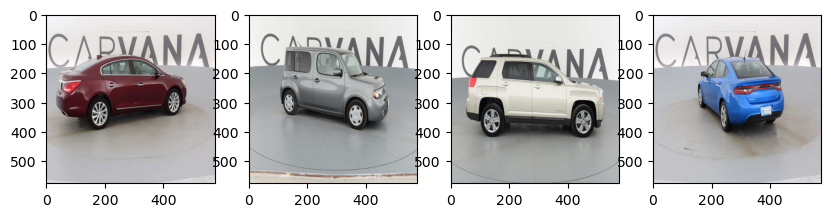

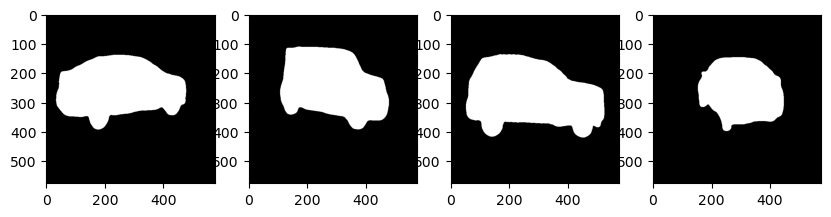

In [21]:
def visualize_result(dataloader):
    tr_imgs = []
    msk_imgs = []
    
    for x, y in dataloader:
        x = x.to(device)
        
        pred = model(x)
        
        for i in range(x.shape[0]):
            tr_img = x[i].cpu().detach().numpy()
            tr_img = np.einsum('kij->ijk',tr_img)
            tr_imgs.append(tr_img)
            
            msk_img = pred[i].cpu().detach().numpy()
            msk_img = msk_img.reshape((img_size, img_size))
            msk_imgs.append(msk_img)

        break
        
    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=True)
    
visualize_result(val_dataloader)

In [22]:
torch.save(model.state_dict(), "model.pth")

In [23]:
# def rle(img):
#     flat_img = img.flatten()
#     flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)
#     flat_img = np.insert(flat_img, [0, len(flat_img)], [0, 0])

#     starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
#     ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
#     starts_ix = np.where(starts)[0] + 1
#     ends_ix = np.where(ends)[0] + 1
#     lengths = ends_ix - starts_ix

#     encoding = ''
#     for idx in range(len(starts_ix)):
#         encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
#     return encoding.strip()

In [24]:
# test_rle = np.zeros((test_images.shape[0]), dtype=object)

# for i in range(test_images.shape[0]):
#     img = np.array(Image.open("/kaggle/working/test/" + test_images[i]))
#     test_rle[i] = rle(img)
    
#     if i % 1000 == 0:
#         print(i)

In [25]:
# df_ans = pd.DataFrame({"img": test_images, "rle_mask": test_rle})

# df_ans

In [26]:
# df_ans.to_csv("ans1.csv", index=False)